# Player Size vs Prediction Error Analysis

This notebook analyzes whether there's a correlation between:
- **Original player size** (width × height in pixels)
- **Prediction error** (angular error in degrees)

**Hypothesis:** Smaller players might be harder to predict due to less visual information.

---

## 1. Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from tqdm.auto import tqdm
import math
from scipy import stats

print("✓ Imports complete")

✓ Imports complete


## 2. Configuration

In [3]:
CONFIG = {
    # Paths
    'dataset_root': '/content/drive/MyDrive/player_direction_dataset',
    'model_path': '/content/drive/MyDrive/player_direction_checkpoints_4059_optimized/best_model.pth',
    'output_dir': '/content/drive/MyDrive/size_error_analysis',

    # Model config
    'image_size': 224,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
}

# Create output directory
Path(CONFIG['output_dir']).mkdir(parents=True, exist_ok=True)

print("Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

Configuration:
  dataset_root: /content/drive/MyDrive/player_direction_dataset
  model_path: /content/drive/MyDrive/player_direction_checkpoints_4059_optimized/best_model.pth
  output_dir: /content/drive/MyDrive/size_error_analysis
  image_size: 224
  device: cuda


## 3. Load Model

In [4]:
# Model definition (same as training)
class PlayerDirectionModel(nn.Module):
    def __init__(self):
        super().__init__()
        from torchvision.models import resnet50, ResNet50_Weights

        # Load pretrained ResNet50
        resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)

        # Use entire ResNet as image encoder
        self.image_encoder = nn.Sequential(*list(resnet.children())[:-1])

        # BBox encoder (output: 32)
        self.bbox_encoder = nn.Sequential(
            nn.Linear(6, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.ReLU(),
        )

        # Fusion (2048 + 32 = 2080 → 256 → 128)
        self.fusion = nn.Sequential(
            nn.Linear(2080, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
        )

        # Direction head (128 → 2)
        self.direction_head = nn.Linear(128, 2)

    def forward(self, image, bbox):
        # Image features through full ResNet
        img_features = self.image_encoder(image)
        img_features = img_features.view(img_features.size(0), -1)  # [B, 2048]

        # BBox features
        bbox_features = self.bbox_encoder(bbox)  # [B, 32]

        # Fuse (2048 + 32 = 2080 → 256 → 128)
        combined = torch.cat([img_features, bbox_features], dim=1)
        fused = self.fusion(combined)  # [B, 128]

        # Predict direction
        direction = self.direction_head(fused)  # [B, 2]
        direction = F.normalize(direction, p=2, dim=1)

        return direction

print("✓ Model class defined")

✓ Model class defined


In [5]:
# Load trained model
device = torch.device(CONFIG['device'])
print(f"Using device: {device}")

model = PlayerDirectionModel().to(device)
checkpoint = torch.load(CONFIG['model_path'], map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"✓ Model loaded from {CONFIG['model_path']}")
print(f"  Checkpoint epoch: {checkpoint.get('epoch', 'N/A')}")
print(f"  Validation MAE: {checkpoint.get('valid_angle_error', 'N/A')}°")

Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 197MB/s]


✓ Model loaded from /content/drive/MyDrive/player_direction_checkpoints_4059_optimized/best_model.pth
  Checkpoint epoch: 74
  Validation MAE: 28.207599053016075°


## 4. Load Test Data with Size Information

In [6]:
# Load test labels
test_labels_path = Path(CONFIG['dataset_root']) / 'test' / 'labels.json'
with open(test_labels_path) as f:
    test_labels = json.load(f)

print(f"✓ Loaded {len(test_labels)} test samples")

# Filter samples with bbox_pitch AND original_size
valid_samples = []
for label in test_labels:
    bbox_pitch = label.get('bbox_pitch')
    original_size = label.get('original_size')

    if bbox_pitch is None or original_size is None:
        continue

    required_bbox = ['x_bottom_left', 'y_bottom_left',
                    'x_bottom_right', 'y_bottom_right',
                    'x_bottom_middle', 'y_bottom_middle']

    if all(k in bbox_pitch for k in required_bbox):
        valid_samples.append(label)

print(f"✓ {len(valid_samples)} valid samples with bbox_pitch and original_size")

# Quick stats on original sizes
widths = [s['original_size'][0] for s in valid_samples]
heights = [s['original_size'][1] for s in valid_samples]
areas = [w * h for w, h in zip(widths, heights)]

print(f"\nOriginal size statistics:")
print(f"  Width:  min={min(widths)}, max={max(widths)}, mean={np.mean(widths):.1f}")
print(f"  Height: min={min(heights)}, max={max(heights)}, mean={np.mean(heights):.1f}")
print(f"  Area:   min={min(areas)}, max={max(areas)}, mean={np.mean(areas):.1f}")

✓ Loaded 407 test samples
✓ 403 valid samples with bbox_pitch and original_size

Original size statistics:
  Width:  min=20, max=137, mean=53.5
  Height: min=54, max=216, mean=111.6
  Area:   min=1160, max=26030, mean=6355.6


## 5. Run Predictions and Collect Results

In [7]:
# Preprocessing
transform = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def vector_to_angle(vector):
    """Convert (cos, sin) to degrees [0, 360)"""
    angle_rad = math.atan2(vector[1], vector[0])
    angle_deg = math.degrees(angle_rad)
    return angle_deg % 360

def angular_error(pred_deg, gt_deg):
    """Calculate angular error in degrees"""
    diff = abs(pred_deg - gt_deg)
    if diff > 180:
        diff = 360 - diff
    return diff

print("✓ Helper functions defined")

✓ Helper functions defined


In [8]:
# Collect results
results = []
failed_count = 0

print(f"Running predictions on {len(valid_samples)} samples...\n")

for sample in tqdm(valid_samples, desc="Processing"):
    try:
        # Load image
        img_path = Path(CONFIG['dataset_root']) / 'test' / 'images' / sample['filename']
        if not img_path.exists():
            failed_count += 1
            continue

        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)

        # Prepare bbox
        bbox_pitch = sample['bbox_pitch']
        bbox_tensor = torch.tensor([
            bbox_pitch['x_bottom_left'] / 34.0,
            bbox_pitch['y_bottom_left'] / 52.5,
            bbox_pitch['x_bottom_right'] / 34.0,
            bbox_pitch['y_bottom_right'] / 52.5,
            bbox_pitch['x_bottom_middle'] / 34.0,
            bbox_pitch['y_bottom_middle'] / 52.5,
        ], dtype=torch.float32).unsqueeze(0).to(device)

        # Predict
        with torch.no_grad():
            pred_direction = model(img_tensor, bbox_tensor)

        pred_vec = pred_direction[0].cpu().numpy()
        pred_angle = vector_to_angle(pred_vec)
        gt_angle = sample['direction_degree']
        error = angular_error(pred_angle, gt_angle)

        # Extract size info
        orig_width, orig_height = sample['original_size']
        orig_area = orig_width * orig_height
        aspect_ratio = orig_width / orig_height if orig_height > 0 else 0

        # Store result
        results.append({
            'filename': sample['filename'],
            'orig_width': orig_width,
            'orig_height': orig_height,
            'orig_area': orig_area,
            'aspect_ratio': aspect_ratio,
            'pred_angle': pred_angle,
            'gt_angle': gt_angle,
            'error': error,
            'source_sequence': sample.get('source_sequence', 'unknown'),
            'team': sample.get('team', 'unknown'),
        })

    except Exception as e:
        print(f"Error processing {sample['filename']}: {e}")
        failed_count += 1
        continue

print(f"\n✓ Processed {len(results)} samples")
print(f"  Failed: {failed_count}")

# Convert to DataFrame
df = pd.DataFrame(results)
print(f"\n✓ Created DataFrame with {len(df)} rows")
print(df.head())

Running predictions on 403 samples...



Processing:   0%|          | 0/403 [00:00<?, ?it/s]


✓ Processed 403 samples
  Failed: 0

✓ Created DataFrame with 403 rows
          filename  orig_width  orig_height  orig_area  aspect_ratio  \
0  test_000000.jpg          46          106       4876      0.433962   
1  test_000001.jpg          54          113       6102      0.477876   
2  test_000002.jpg          99          164      16236      0.603659   
3  test_000003.jpg          79          150      11850      0.526667   
4  test_000004.jpg          98          167      16366      0.586826   

   pred_angle    gt_angle      error source_sequence   team  
0  324.836286  270.511556  54.324730        SNGS-169  right  
1  358.974197   83.224344  84.250147        SNGS-157  right  
2  290.251433  349.186122  58.934689        SNGS-083  right  
3  350.139046  347.680555   2.458491        SNGS-037  right  
4  270.382570  270.000000   0.382570        SNGS-024   left  


## 6. Statistical Analysis

In [9]:
print("="*70)
print("STATISTICAL ANALYSIS: SIZE vs ERROR")
print("="*70)

# Overall statistics
print(f"\nOverall Performance:")
print(f"  Mean Error: {df['error'].mean():.2f}°")
print(f"  Median Error: {df['error'].median():.2f}°")
print(f"  Std Error: {df['error'].std():.2f}°")

# Correlation analysis
print(f"\nCorrelation with Error:")
correlations = {
    'Width': df['orig_width'].corr(df['error']),
    'Height': df['orig_height'].corr(df['error']),
    'Area': df['orig_area'].corr(df['error']),
    'Aspect Ratio': df['aspect_ratio'].corr(df['error']),
}

for metric, corr in correlations.items():
    print(f"  {metric:15s}: r={corr:+.4f}")

# Significance tests
print(f"\nPearson Correlation Tests:")
for metric in ['orig_width', 'orig_height', 'orig_area', 'aspect_ratio']:
    r, p_value = stats.pearsonr(df[metric], df['error'])
    sig = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
    print(f"  {metric:15s}: r={r:+.4f}, p={p_value:.4f} {sig}")

# Size quartiles analysis
print(f"\nError by Area Quartiles:")
df['area_quartile'] = pd.qcut(df['orig_area'], q=4, labels=['Q1 (smallest)', 'Q2', 'Q3', 'Q4 (largest)'])
quartile_stats = df.groupby('area_quartile')['error'].agg(['mean', 'median', 'std', 'count'])
print(quartile_stats)

# Width quartiles
print(f"\nError by Width Quartiles:")
df['width_quartile'] = pd.qcut(df['orig_width'], q=4, labels=['Q1 (narrowest)', 'Q2', 'Q3', 'Q4 (widest)'])
width_stats = df.groupby('width_quartile')['error'].agg(['mean', 'median', 'std', 'count'])
print(width_stats)

# Height quartiles
print(f"\nError by Height Quartiles:")
df['height_quartile'] = pd.qcut(df['orig_height'], q=4, labels=['Q1 (shortest)', 'Q2', 'Q3', 'Q4 (tallest)'])
height_stats = df.groupby('height_quartile')['error'].agg(['mean', 'median', 'std', 'count'])
print(height_stats)

STATISTICAL ANALYSIS: SIZE vs ERROR

Overall Performance:
  Mean Error: 35.73°
  Median Error: 27.39°
  Std Error: 35.20°

Correlation with Error:
  Width          : r=+0.1900
  Height         : r=+0.0872
  Area           : r=+0.1570
  Aspect Ratio   : r=+0.1835

Pearson Correlation Tests:
  orig_width     : r=+0.1900, p=0.0001 ***
  orig_height    : r=+0.0872, p=0.0805 ns
  orig_area      : r=+0.1570, p=0.0016 **
  aspect_ratio   : r=+0.1835, p=0.0002 ***

Error by Area Quartiles:
                    mean     median        std  count
area_quartile                                        
Q1 (smallest)  31.681140  25.516187  33.274692    101
Q2             30.759623  23.202107  29.246397    101
Q3             36.710642  27.945246  34.647208    100
Q4 (largest)   43.785183  36.047899  41.506119    101

Error by Width Quartiles:
                     mean     median        std  count
width_quartile                                        
Q1 (narrowest)  33.063959  27.420802  31.771908    1

/tmp/ipython-input-3784783359.py:33: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  quartile_stats = df.groupby('area_quartile')['error'].agg(['mean', 'median', 'std', 'count'])
/tmp/ipython-input-3784783359.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  width_stats = df.groupby('width_quartile')['error'].agg(['mean', 'median', 'std', 'count'])
/tmp/ipython-input-3784783359.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this 

## 7. Visualizations

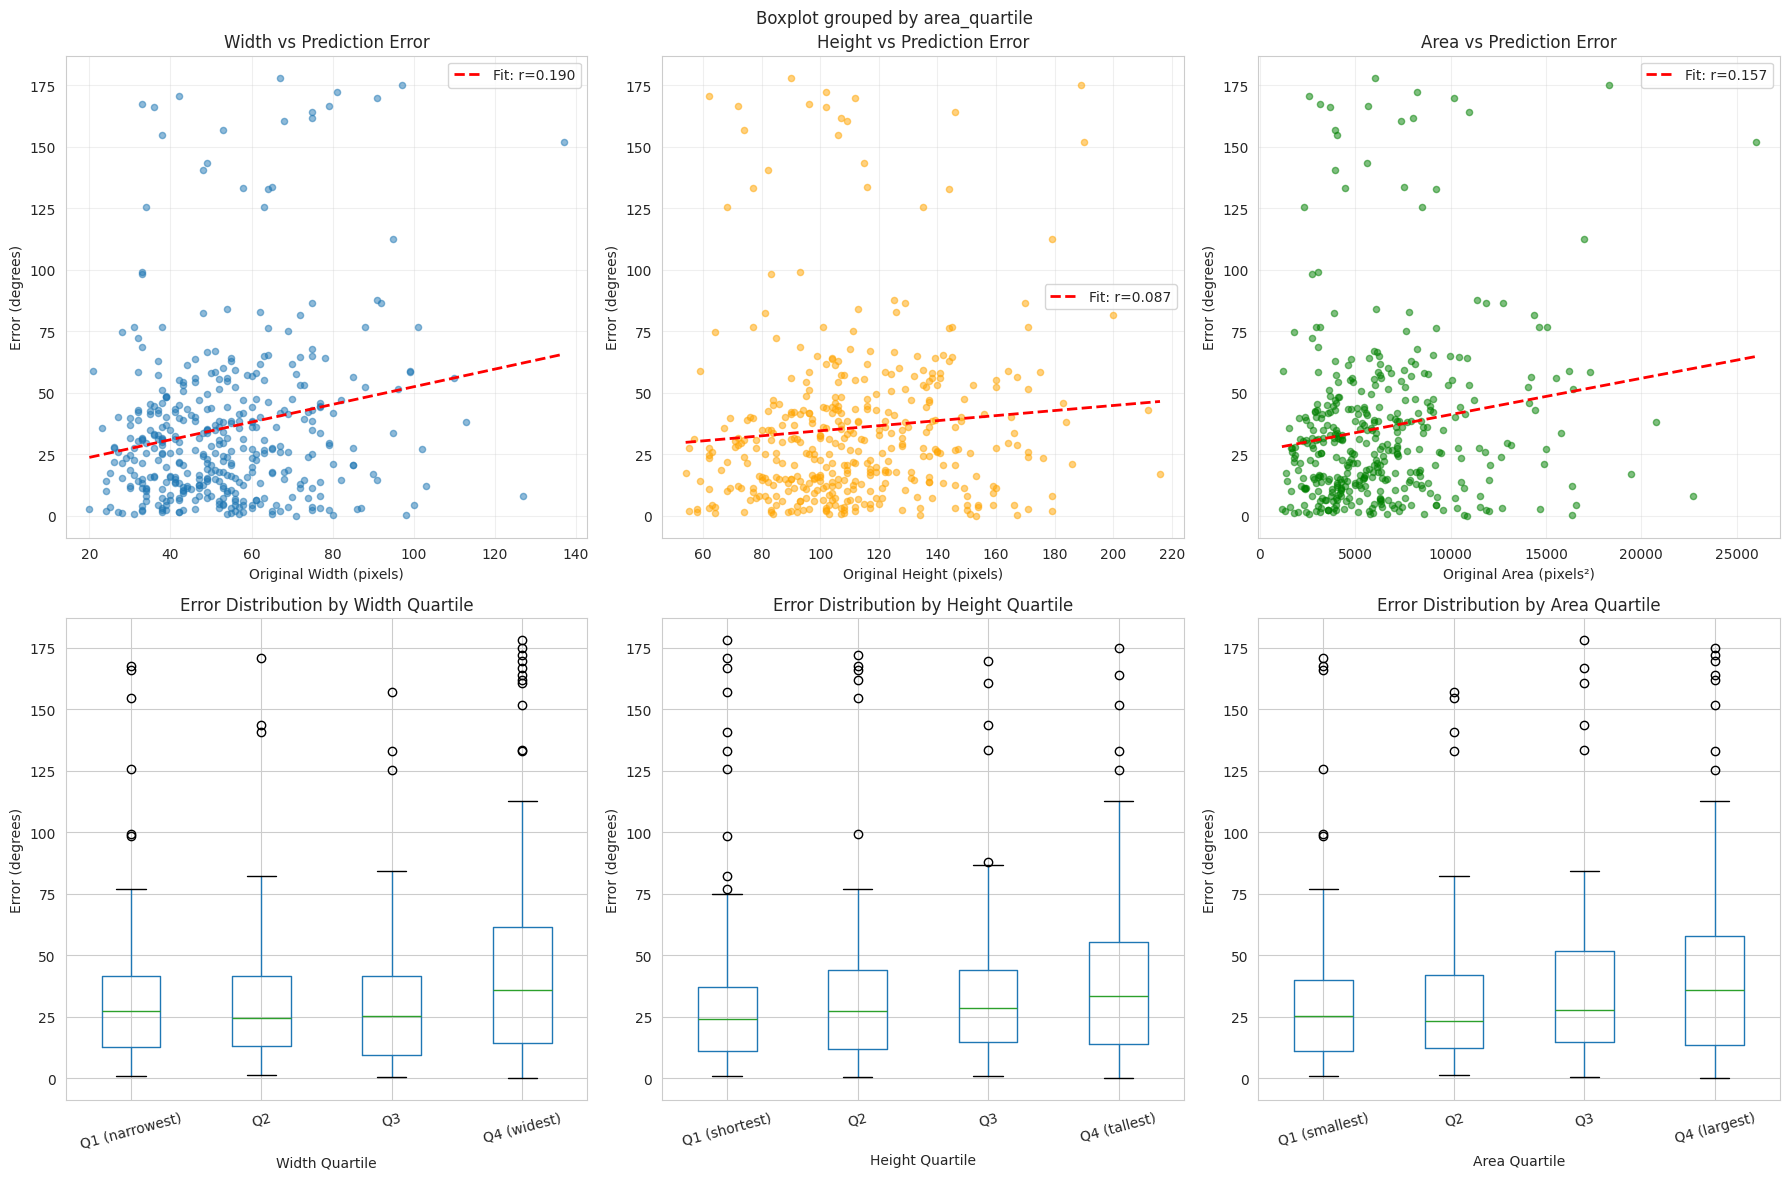


✓ Saved: size_vs_error_analysis.png


In [10]:
# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Width vs Error (scatter)
ax = axes[0, 0]
ax.scatter(df['orig_width'], df['error'], alpha=0.5, s=20)
z = np.polyfit(df['orig_width'], df['error'], 1)
p = np.poly1d(z)
ax.plot(df['orig_width'].sort_values(), p(df['orig_width'].sort_values()),
        "r--", linewidth=2, label=f'Fit: r={correlations["Width"]:.3f}')
ax.set_xlabel('Original Width (pixels)')
ax.set_ylabel('Error (degrees)')
ax.set_title('Width vs Prediction Error')
ax.legend()
ax.grid(alpha=0.3)

# 2. Height vs Error (scatter)
ax = axes[0, 1]
ax.scatter(df['orig_height'], df['error'], alpha=0.5, s=20, color='orange')
z = np.polyfit(df['orig_height'], df['error'], 1)
p = np.poly1d(z)
ax.plot(df['orig_height'].sort_values(), p(df['orig_height'].sort_values()),
        "r--", linewidth=2, label=f'Fit: r={correlations["Height"]:.3f}')
ax.set_xlabel('Original Height (pixels)')
ax.set_ylabel('Error (degrees)')
ax.set_title('Height vs Prediction Error')
ax.legend()
ax.grid(alpha=0.3)

# 3. Area vs Error (scatter)
ax = axes[0, 2]
ax.scatter(df['orig_area'], df['error'], alpha=0.5, s=20, color='green')
z = np.polyfit(df['orig_area'], df['error'], 1)
p = np.poly1d(z)
ax.plot(df['orig_area'].sort_values(), p(df['orig_area'].sort_values()),
        "r--", linewidth=2, label=f'Fit: r={correlations["Area"]:.3f}')
ax.set_xlabel('Original Area (pixels²)')
ax.set_ylabel('Error (degrees)')
ax.set_title('Area vs Prediction Error')
ax.legend()
ax.grid(alpha=0.3)

# 4. Error by Width Quartile (box plot)
ax = axes[1, 0]
df.boxplot(column='error', by='width_quartile', ax=ax)
ax.set_xlabel('Width Quartile')
ax.set_ylabel('Error (degrees)')
ax.set_title('Error Distribution by Width Quartile')
plt.sca(ax)
plt.xticks(rotation=15)

# 5. Error by Height Quartile (box plot)
ax = axes[1, 1]
df.boxplot(column='error', by='height_quartile', ax=ax)
ax.set_xlabel('Height Quartile')
ax.set_ylabel('Error (degrees)')
ax.set_title('Error Distribution by Height Quartile')
plt.sca(ax)
plt.xticks(rotation=15)

# 6. Error by Area Quartile (box plot)
ax = axes[1, 2]
df.boxplot(column='error', by='area_quartile', ax=ax)
ax.set_xlabel('Area Quartile')
ax.set_ylabel('Error (degrees)')
ax.set_title('Error Distribution by Area Quartile')
plt.sca(ax)
plt.xticks(rotation=15)

plt.tight_layout()
plt.savefig(Path(CONFIG['output_dir']) / 'size_vs_error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved: size_vs_error_analysis.png")

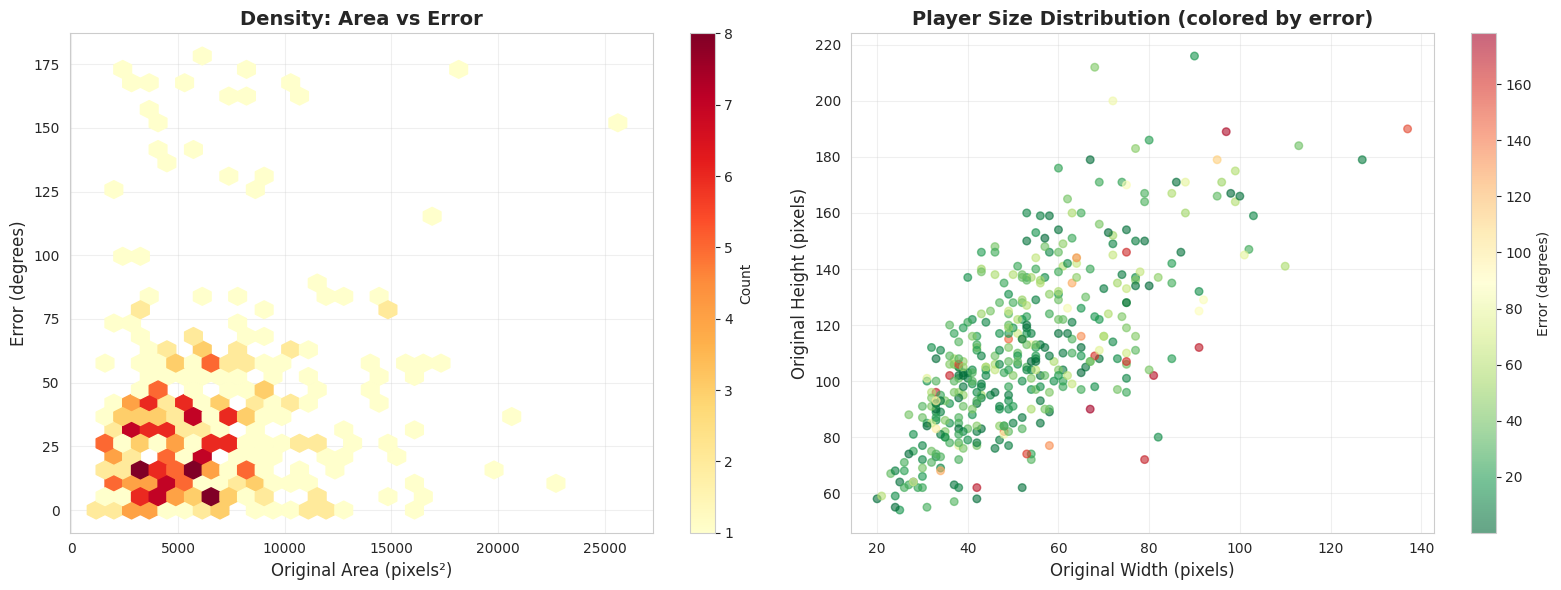


✓ Saved: size_distribution_analysis.png


In [11]:
# Additional visualization: 2D density plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Area vs Error (hexbin)
ax = axes[0]
hexbin = ax.hexbin(df['orig_area'], df['error'], gridsize=30, cmap='YlOrRd', mincnt=1)
ax.set_xlabel('Original Area (pixels²)', fontsize=12)
ax.set_ylabel('Error (degrees)', fontsize=12)
ax.set_title('Density: Area vs Error', fontsize=14, fontweight='bold')
plt.colorbar(hexbin, ax=ax, label='Count')
ax.grid(alpha=0.3)

# Width vs Height colored by error
ax = axes[1]
scatter = ax.scatter(df['orig_width'], df['orig_height'],
                    c=df['error'], cmap='RdYlGn_r', s=30, alpha=0.6)
ax.set_xlabel('Original Width (pixels)', fontsize=12)
ax.set_ylabel('Original Height (pixels)', fontsize=12)
ax.set_title('Player Size Distribution (colored by error)', fontsize=14, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax, label='Error (degrees)')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(Path(CONFIG['output_dir']) / 'size_distribution_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Saved: size_distribution_analysis.png")

## 8. Save Results

In [12]:
# Save full results
output_file = Path(CONFIG['output_dir']) / 'size_error_results.csv'
df.to_csv(output_file, index=False)
print(f"✓ Saved detailed results: {output_file}")

# Save summary statistics
summary = {
    'overall_stats': {
        'mean_error': float(df['error'].mean()),
        'median_error': float(df['error'].median()),
        'std_error': float(df['error'].std()),
        'total_samples': len(df)
    },
    'correlations': correlations,
    'quartile_analysis': {
        'by_area': quartile_stats.to_dict(),
        'by_width': width_stats.to_dict(),
        'by_height': height_stats.to_dict()
    }
}

summary_file = Path(CONFIG['output_dir']) / 'summary_statistics.json'
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✓ Saved summary statistics: {summary_file}")

✓ Saved detailed results: /content/drive/MyDrive/size_error_analysis/size_error_results.csv
✓ Saved summary statistics: /content/drive/MyDrive/size_error_analysis/summary_statistics.json


## 9. Conclusions

In [13]:
print("="*70)
print("CONCLUSIONS")
print("="*70)

# Interpret correlations
print("\n1. CORRELATION STRENGTH:")
for metric, corr in correlations.items():
    if abs(corr) < 0.1:
        strength = "negligible"
    elif abs(corr) < 0.3:
        strength = "weak"
    elif abs(corr) < 0.5:
        strength = "moderate"
    elif abs(corr) < 0.7:
        strength = "strong"
    else:
        strength = "very strong"

    direction = "negative" if corr < 0 else "positive"
    print(f"   {metric}: {strength} {direction} correlation (r={corr:+.4f})")

# Compare quartiles
print("\n2. QUARTILE COMPARISON:")
q1_error = quartile_stats.loc['Q1 (smallest)', 'mean']
q4_error = quartile_stats.loc['Q4 (largest)', 'mean']
diff = q1_error - q4_error
pct_diff = (diff / q4_error) * 100

print(f"   Smallest players (Q1): {q1_error:.2f}° MAE")
print(f"   Largest players (Q4):  {q4_error:.2f}° MAE")
print(f"   Difference: {diff:+.2f}° ({pct_diff:+.1f}%)")

if abs(diff) < 2:
    conclusion = "No significant impact"
elif diff > 0:
    conclusion = "Smaller players are harder to predict"
else:
    conclusion = "Larger players are harder to predict"

print(f"   → {conclusion}")

print("\n3. KEY FINDINGS:")
print(f"   • Sample size: {len(df)} test samples")
print(f"   • Size range: {df['orig_area'].min():.0f} - {df['orig_area'].max():.0f} pixels²")
print(f"   • Error range: {df['error'].min():.1f}° - {df['error'].max():.1f}°")
print(f"   • Correlation area-error: r={correlations['Area']:.4f}")

if abs(correlations['Area']) < 0.1:
    print("\n   ✓ Player size has MINIMAL impact on prediction accuracy")
    print("   ✓ Model is robust across different player sizes")
elif correlations['Area'] < -0.2:
    print("\n   ⚠ Smaller players show higher errors")
    print("   → Consider data augmentation for small players")
elif correlations['Area'] > 0.2:
    print("\n   ⚠ Larger players show higher errors")
    print("   → May need to handle close-up players differently")

print("\n" + "="*70)

CONCLUSIONS

1. CORRELATION STRENGTH:
   Width: weak positive correlation (r=+0.1900)
   Height: negligible positive correlation (r=+0.0872)
   Area: weak positive correlation (r=+0.1570)
   Aspect Ratio: weak positive correlation (r=+0.1835)

2. QUARTILE COMPARISON:
   Smallest players (Q1): 31.68° MAE
   Largest players (Q4):  43.79° MAE
   Difference: -12.10° (-27.6%)
   → Larger players are harder to predict

3. KEY FINDINGS:
   • Sample size: 403 test samples
   • Size range: 1160 - 26030 pixels²
   • Error range: 0.0° - 178.2°
   • Correlation area-error: r=0.1570

